## Homework

Complete task:
1) Find texts about cats, add 100+ random entries with text about cats and change its label to "Cat".You can add 'cats texts' to already used dataset in the notebook example
2) Train the model to classify and catch texts about cats


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import re
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Loading data


In [33]:
df = pd.read_excel("Dataset.xlsx")

df.head()

,Text,Target
0,"I sipped my coffee slowly, savoring the rich a...",NoN_Cat
1,"The leaves rustled in the gentle breeze, creat...",NoN_Cat
2,My thoughts wandered aimlessly as I stared out...,NoN_Cat
3,"A soft rain began to fall, tapping lightly aga...",NoN_Cat
4,"I curled up with a good book, escaping into it...",NoN_Cat


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    299 non-null    object
 1   Target  299 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


<Axes: >

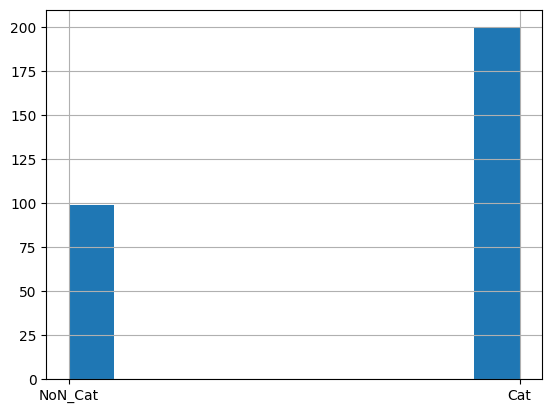

In [35]:
df['Target'].hist()

## Map classes to the integers

In [36]:
target_map = {'NoN_Cat': 0, 'Cat': 1}
df['Target'] = df['Target'].map(target_map)

df.head()

,Text,Target
0,"I sipped my coffee slowly, savoring the rich a...",0
1,"The leaves rustled in the gentle breeze, creat...",0
2,My thoughts wandered aimlessly as I stared out...,0
3,"A soft rain began to fall, tapping lightly aga...",0
4,"I curled up with a good book, escaping into it...",0


In [37]:
df1 = df[['Text', 'Target']]
df1.columns = ['sentence', 'label']
df1.to_csv('data.csv', index=False)

In [38]:
from datasets import load_dataset
# Uses the “load_dataset” function to load a dataset stored in a CSV file named “data.csv”, which we have stored above.
raw_dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 299 examples [00:00, 32957.45 examples/s]


In [39]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 299
    })
})

In [40]:
split = raw_dataset['train'].train_test_split(test_size=0.2, seed=24)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 239
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 60
    })
})

## Tokenize the data

In [41]:
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased' 
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

In [42]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation=True)

In [43]:
tokenized_dataset = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/239 [00:00<?, ? examples/s]

Map: 100%|██████████| 60/60 [00:00<00:00, 1660.26 examples/s]


In [44]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [45]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [47]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [48]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='micro')
  return {'accuracy': acc, 'f1_score': f1}

In [49]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

C:\Users\38098\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [50]:
trainer.train()

                                               
 33%|███▎      | 15/45 [00:59<01:59,  3.99s/it]Checkpoint destination directory training_dir\checkpoint-15 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.058907561004161835, 'eval_accuracy': 1.0, 'eval_f1_score': 1.0, 'eval_runtime': 3.7989, 'eval_samples_per_second': 15.794, 'eval_steps_per_second': 0.263, 'epoch': 1.0}


 67%|██████▋   | 30/45 [02:12<01:05,  4.36s/it]Checkpoint destination directory training_dir\checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.00888767372816801, 'eval_accuracy': 1.0, 'eval_f1_score': 1.0, 'eval_runtime': 3.5305, 'eval_samples_per_second': 16.995, 'eval_steps_per_second': 0.283, 'epoch': 2.0}


100%|██████████| 45/45 [03:15<00:00,  4.21s/it]Checkpoint destination directory training_dir\checkpoint-45 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.005734686274081469, 'eval_accuracy': 1.0, 'eval_f1_score': 1.0, 'eval_runtime': 3.9913, 'eval_samples_per_second': 15.033, 'eval_steps_per_second': 0.251, 'epoch': 3.0}


100%|██████████| 45/45 [03:17<00:00,  4.39s/it]

{'train_runtime': 197.6593, 'train_samples_per_second': 3.627, 'train_steps_per_second': 0.228, 'train_loss': 0.1293468475341797, 'epoch': 3.0}


TrainOutput(global_step=45, training_loss=0.1293468475341797, metrics={'train_runtime': 197.6593, 'train_samples_per_second': 3.627, 'train_steps_per_second': 0.228, 'train_loss': 0.1293468475341797, 'epoch': 3.0})

## Evaluate the model

In [51]:
%ls training_dir

 Volume in drive E is ����� ⮬
 Volume Serial Number is F29B-A6C3

 Directory of e:\Camp all task\Task_35.(llm)\training_dir

18.03.2024  19:11    <DIR>          .
18.03.2024  19:11    <DIR>          ..
18.03.2024  19:08    <DIR>          checkpoint-15
18.03.2024  19:10    <DIR>          checkpoint-30
18.03.2024  19:11    <DIR>          checkpoint-45
18.03.2024  19:03    <DIR>          runs
               0 File(s)              0 bytes
               6 Dir(s)  187�203�198�976 bytes free


In [52]:
from transformers import pipeline

In [53]:
saved_model = pipeline('text-classification',
                       model='training_dir/checkpoint-30')

In [54]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 60
})

In [55]:
predictions = saved_model(split['test']['sentence'])

In [56]:
# printout few predictions
predictions[:10]

[{'label': 'LABEL_1', 'score': 0.9958258867263794},
 {'label': 'LABEL_1', 'score': 0.9954560995101929},
 {'label': 'LABEL_1', 'score': 0.9957365989685059},
 {'label': 'LABEL_0', 'score': 0.9811649322509766},
 {'label': 'LABEL_1', 'score': 0.9958433508872986},
 {'label': 'LABEL_1', 'score': 0.9949671626091003},
 {'label': 'LABEL_1', 'score': 0.9956305027008057},
 {'label': 'LABEL_1', 'score': 0.9958251714706421},
 {'label': 'LABEL_1', 'score': 0.995812714099884},
 {'label': 'LABEL_1', 'score': 0.9943501353263855}]

In [57]:
def get_label(d):
  return int(d['label'].split('_')[1])


predictions = [get_label(d) for d in predictions]

In [58]:
print("acc:", accuracy_score(split['test']['label'], predictions))

acc: 1.0


In [59]:
# Calculate f1 score
print("f1:", f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 1.0


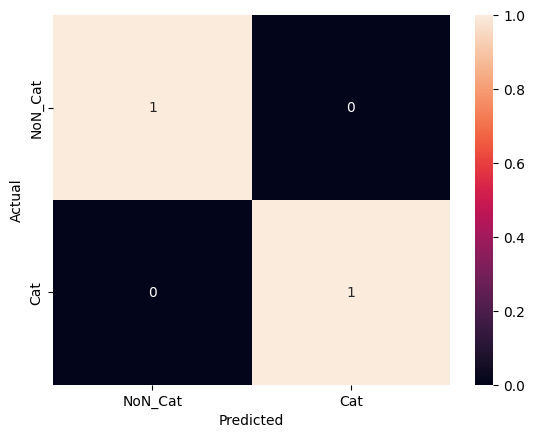

In [60]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['NoN_Cat', 'Cat']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'], predictions, normalize='true')
plot_cm(cm)